## Import the useful library and the dataset

In [113]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_excel("../Datasets/Dry_Bean_Dataset.xlsx")
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [114]:
X = df.drop(columns=['Class']).values
y = df['Class'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)
Xtrain.shape

(10888, 16)

## Preprocess data by centering the variables and dividing them by their standard deviation.

In [115]:
# we use sklearn to prerocess
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## My algorithm to perform PCA

In [116]:
def my_PCA(X_std, k):
    """
    X: dataframe
        dataframe with n observation and p features
    k: int
        number of components
    output: array-shape
        return the dataset projected onto the k most significative directions
    """
  
    cov_mat = np.cov(X_std.T)

    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    #print('eig_val:', eig_vals)
    #print('eig_vecs:', eig_vecs)

    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]
    #print('sorted_indeces:', sorted_indices)
    #print('sorted_eigvec:', sorted_eigvecs)
    

    #num_features = X_std.shape[1]
    #print(num_features)
    explained_variance_ratio = eig_vals / np.sum(eig_vals)
    fidelity_variance_ratio = np.cumsum(explained_variance_ratio)
    
    top_k_eigvecs = sorted_eigvecs[:k]
    #print(top_k_eigvecs.shape)
    #print('top_k:', top_k_eigvecs)

    X_pca = X_std.dot(top_k_eigvecs.T)
    return X_pca

[5.54664386e-01 2.64309732e-01 8.00656423e-02 5.11408028e-02
 2.73929290e-02 1.14976094e-02 6.97650736e-03 3.25082499e-03
 5.16266363e-04 9.08681217e-05 6.58867931e-05 1.83739299e-05
 9.29966430e-06 6.25641773e-07 1.34132085e-07 1.11549495e-07]


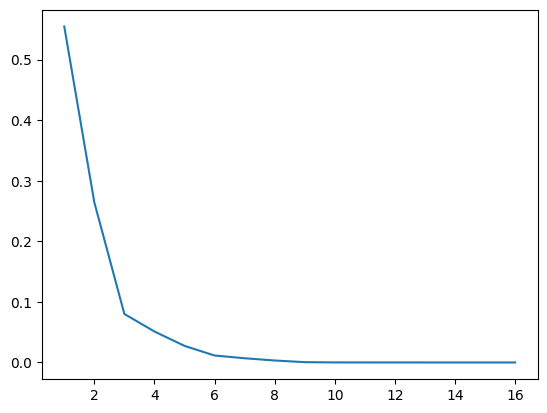

In [117]:
from matplotlib import pyplot as plt

def find_best_k(X_std):
    cov_mat = np.cov(X_std.T)

    eig_vals = np.linalg.eig(cov_mat)[0]

    lambdas = sorted(eig_vals, reverse=True)/np.sum(eig_vals)
    print(lambdas)

    dim = [i for i in range(1,X_std.shape[1]+1)]

    plt.plot(dim, lambdas)


find_best_k(X_std)

In [122]:
## check the leveles of y, and change it so that we can associate a color to each class
df['Class'].value_counts()

# create a dictionary to map categories to numbers
category_numbers = {category: num for num, category in enumerate(df['Class'].unique())}

# apply the mapping to the 'category' column using the map() function
df['Class'] = df['Class'].map(category_numbers)

y = df['Class'].values



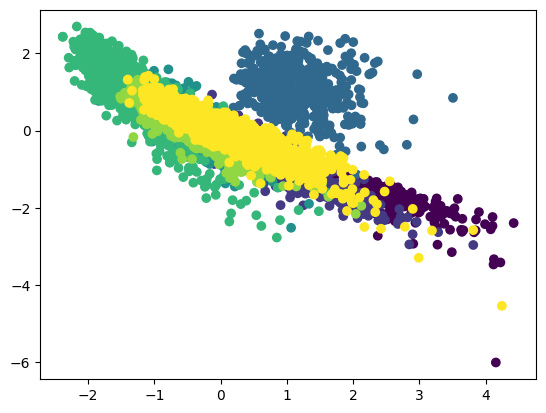

In [123]:
## Project the data (training set) in the first two principal components and color by class. Do it also for three principal components.
proj_to_2 = my_PCA(X_std,2)

first_comp = [proj_to_2[i][0] for i in range(X_std.shape[0])]
second_comp = [proj_to_2[i][1] for i in range(X_std.shape[0])]

plt.scatter(first_comp,second_comp, c = y)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


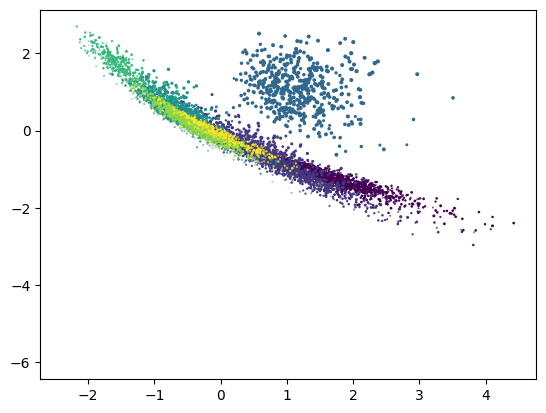

In [124]:
## Project the data (training set) in the first 3 principal components and color by class. Do it also for three principal components.
proj_to_3 = my_PCA(X_std,3)

first_comp = [proj_to_3[i][0] for i in range(X_std.shape[0])]
second_comp = [proj_to_3[i][1] for i in range(X_std.shape[0])]
third_comp = [proj_to_3[i][2] for i in range(X_std.shape[0])]

plt.scatter(first_comp,second_comp, third_comp, c = y)

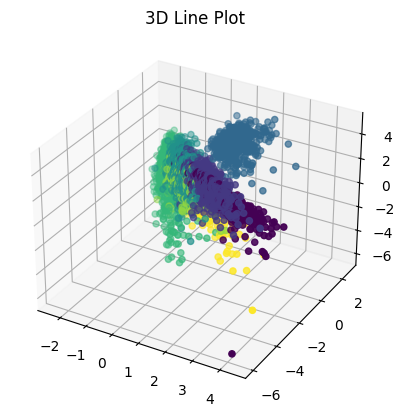

In [127]:
# create a 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')

# plot the data
ax.scatter(first_comp, second_comp, third_comp, c = y)

# set the plot title and labels
ax.set_title('3D Line Plot')

# show the plot
plt.show()